In [1]:
import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from G_model import model_single_timestep_S

pd.options.mode.chained_assignment = None  # Suppress the warning

In [2]:
# Load parameters from YAML file
with open('config/parameters.yml', 'r') as file:
    param = yaml.safe_load(file)

In [3]:
# Load data
df_batch1 = pd.read_csv('data/batch_no1/generated data/df_gen_co2_1.csv')
df_batch1.drop(['Unnamed: 0'], axis=1, inplace=True)
df_batch1['batch_id'] = df_batch1['batch_id'].astype(str).str.zfill(3)
# check of all NaN are removed
df_batch1.isna().sum()

time        0
biomass     0
glucose     0
co2         0
batch_id    0
dtype: int64

In [ ]:
# Load data
df_batch2 = pd.read_csv('data/batch_no2/generated data/df_gen_co2_1.csv')
df_batch2.drop(['Unnamed: 0'], axis=1, inplace=True)
df_batch2['batch_id'] = df_batch2['batch_id'].astype(str).str.zfill(3)
# check of all NaN are removed
df_batch2.isna().sum()

In [4]:
# Normalization for batch 1
df_norm_1 = df_batch1.drop(['time', 'batch_id'], axis=1).copy()
mean = df_norm_1.mean()
std = df_norm_1.std()
df_norm_1 = (df_norm_1 - mean) / std
df_norm_1['time'] = df_batch1['time']
df_norm_1['batch_id'] = df_batch1['batch_id']

In [ ]:
# Normalization for batch 2
df_norm_2 = df_batch2.drop(['time', 'batch_id'], axis=1).copy()
mean = df_norm_2.mean()
std = df_norm_2.std()
df_norm_2 = (df_norm_2 - mean) / std
df_norm_2['time'] = df_batch2['time']
df_norm_2['batch_id'] = df_batch2['batch_id']

In [5]:
# group the df by batch_id and take the maximum value of qs
## output is an array (shape: [50,2]) which contains all unique batch_ids and a corresponding max qs
# based on the mean value a binary col is created
## when splitting the data in train & test it is ensured that high and low values of qs are equally distributed
df_grouped = df_norm_1.groupby('batch_id')['glucose'].max().reset_index()
mean_S = df_grouped['glucose'].mean()
df_grouped['bin'] = df_grouped['glucose'].apply(lambda x: 1 if x > mean_S else 0)

# Split in the list of unique batch_ids into train and test
## I take the batch_ids instead of the whole dataset because otherwise snippets of one batch can be in
## both train and test set
## result is better because it has already seen the data
b_train, b_test = train_test_split(df_grouped, test_size=0.2, stratify=df_grouped['bin'], random_state=42)

In [6]:
b_train = list(b_train['batch_id'].values)
b_test = list(b_test['batch_id'].values)

df_train = df_batch1[df_batch1['batch_id'].isin(b_train)]
df_test = df_batch1[df_batch1['batch_id'].isin(b_test)]

# Define X and y
X_train = df_train.copy().drop(['glucose'], axis=1)
y_train = df_train['glucose'].values

X_test = df_test.copy().drop(['glucose'], axis=1)
y_test = df_test['glucose'].values

In [ ]:
# batch 2
X_test_2 = df_norm_2.copy().drop(['glucose'], axis=1)
y_test_2 = df_norm_2['glucose'].values

In [7]:
model = RandomForestRegressor(n_estimators=50, min_samples_leaf=15 ,random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=15, n_estimators=50, random_state=42)

##### Batch No1

In [8]:
batch_ids = X_test['batch_id'].unique()
one_batch = X_test[X_test['batch_id'] == batch_ids[0]]

In [9]:
df_hybrid_batch1 = pd.DataFrame()

for b in range(len(batch_ids)):
    one_batch = X_test[X_test['batch_id'] == batch_ids[b]]

    # Simulation settings
    t0 = 0
    t_end = 45.8
    delta_t = 2
    dt = delta_t/60
    num_steps = int((t_end - t0) / dt) + 1 # Number of time steps

    time = np.linspace(t0, t_end, num_steps)
    biomass = np.zeros(num_steps)
    substrate = np.zeros(num_steps)
    co2 = np.zeros(num_steps)
    volume = np.zeros(num_steps)

    # Extract parameters
    X0 = param['X0']
    S0 = param['S0']
    co20 = param['co20']
    V0 = param['V0']

    # Set initial values
    biomass[0] = X0
    substrate[0] = S0
    co2[0] = co20
    volume[0] = V0
    
    for i in range(1, num_steps):
        # calculating qs    
        input = one_batch.iloc[[i]]
        c_glucose = model.predict(input)

        # previous values
        c_biomass = biomass[i-1]
        c_co2 = co2[i-1]
        vol = volume[i-1]

        # new values from model
        biomass[i], substrate[i], co2[i], volume[i] = model_single_timestep_S(i, c_glucose, c_biomass, c_co2, vol)
    
    one_batch['biomass_sim'] = biomass
    one_batch['glucose_sim'] = substrate
    one_batch['co2_sim'] = co2
    one_batch['volume_sim'] = volume

    df_hybrid_batch1 = pd.concat([df_hybrid_batch1, one_batch])

In [10]:
batch_ids_hybrid = df_hybrid_batch1['batch_id'].unique()
batch_ids_hybrid[:10]

array(['001', '005', '016', '030', '042', '043', '072', '075', '077',
       '092'], dtype=object)

In [24]:
one_batch_hybrid = df_hybrid_batch1[df_hybrid_batch1['batch_id'] == '001']
one_batch_plot = X_test[X_test['batch_id'] == '001']

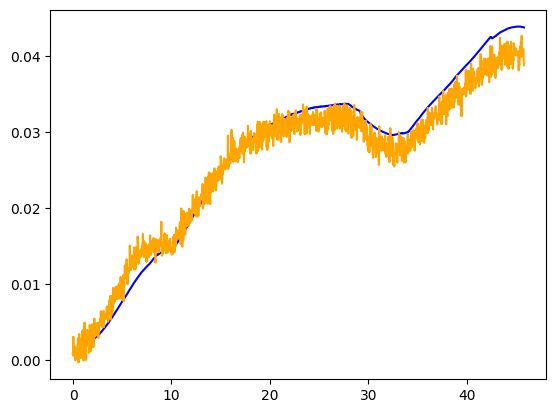

In [26]:
plt.plot(one_batch_hybrid['time'], one_batch_hybrid['co2_sim'], color='blue')
plt.plot(one_batch_plot['time'], one_batch_plot['co2'], color='orange')

##### Batch No2

In [ ]:
batch_ids_2 = X_test_2['batch_id'].unique()
df_hybrid_batch2 = pd.DataFrame()

for b in range(len(batch_ids_2)):
    one_batch = X_test_2[X_test_2['batch_id'] == batch_ids_2[b]]

    # Simulation settings
    t0 = 0
    t_end = 45.8
    delta_t = 2
    dt = delta_t/60
    num_steps = int((t_end - t0) / dt) + 1 # Number of time steps

    time = np.linspace(t0, t_end, num_steps)
    biomass = np.zeros(num_steps)
    substrate = np.zeros(num_steps)
    co2 = np.zeros(num_steps)
    volume = np.zeros(num_steps)

    # Extract parameters
    X0 = param['X0']
    S0 = param['S0']
    co20 = param['co20']
    V0 = param['V0']

    # Set initial values
    biomass[0] = X0
    substrate[0] = S0
    co2[0] = co20
    volume[0] = V0
    
    for i in range(1, num_steps):
        # calculating qs    
        input = one_batch.iloc[[i]]
        c_glucose = model.predict(input)

        # previous values
        c_biomass = biomass[i-1]
        c_co2 = co2[i-1]
        vol = volume[i-1]

        # new values from model
        biomass[i], substrate[i], co2[i], volume[i] = model_single_timestep_S(i, c_glucose, c_biomass, c_co2, vol)
    
    one_batch['biomass_sim'] = biomass
    one_batch['glucose_sim'] = substrate
    one_batch['co2_sim'] = co2
    one_batch['volume_sim'] = volume

    df_hybrid_batch2 = pd.concat([df_hybrid_batch2, one_batch])